<a id="index"></a>
# Data Vizualisation, Gkortzis et al. - JSS'19 Special Issue on Software and Systems Reuse in the Big Data Era 
This notebook performs the following analyses reported in the study:

1. [Prepare dataset](#prepare)
2. [RQ1](#rq1)
    1. [Descriptive statistics](#rq1-descriptive)
    2. [Descriptive statistics (sums & median)](#rq1-sums)
    4. [Regression Analysis (Prepare dataset)](#rq1-regression)
    5. [Dataset Visualization](#rq1-visual)
    6. [Multivariate Regression Analysis](#rq1-regression-multivariate)
    7. [rq1-boxplots](#rq1-boxplots)
<!--    7. [Boxplots](#rq1-boxplots) -->
<!--     8. [Grouping analysis(NEW)](#grouping) -->
3. [RQ2](#rq2)
    1. [Prepare Dataset](#rq2-pd)
    2. [Scatterplots](#rq2-scatter)
    3. [Boxplots](#rq2-boxplots2)
    4. [Regression Analysis [vuln-density, reuse-ratio]](#rq2-regression)
    5. [Regression Analysis [native-vuln-density, reuse-ratio]](#rq2-regression2)
    6. [Multivariate Regression Analysis [vuln-density, native-sloc, reuse-sloc]](#rq2-regression3)
    7. [Multivariate Regression Analysis [vuln-density, native-vuln-density, reuse-vuln-density]](#rq2-regression4)
4. [RQ3](#rq3)
    1. [Dataset Description](#rq3-dd)
    2. [Regression Analysis [#cves-#dependencies]](#rq3-regression)
    3. [RQ3 - Regression Analysis [#v - #dependencies]](#rq3-potential)
    3. [Regression Analysis [#cves - #module_size]](#rq3-regression2)
    4. [Regression Analysis [#cve-density - #dependencies]](#rq3-regression3)
    3. [Count Vulnerable Projects](#rq3-count)
5. [RQ4](#rq4)
    1. [Prepare Dataset](#rq4-pd)
    2. [Count Vulnerabilities](#rq4-count)
    3. [Regression Analysis](#rq4-regression)
6. [[Discussion] How are potential vulnerabilities related to disclosed ones?](#discussion)

<a id="prepare"></a>
## Prepare dataset

In [1]:
import csv
import logging
import numpy as np
import pandas as pd
logging.basicConfig(level=logging.INFO)

def map_deps_to_projects(dependencies_usages):
    logging.info("Creating projects dependencies' list..")
    
    projects_dependencies = {}
    with open(dependencies_usages, 'r') as csv_file:
        for line in csv_file:
            fields = line.replace('\n','').split(';')
#             logging.info(fields)
            dependency = fields[0]
            for project in fields[2:]:
                if project not in projects_dependencies:
                    projects_dependencies[project] = [dependency]
                else:
                    projects_dependencies[project].append(dependency)
                    
    return projects_dependencies


def count_vulnerabilities(projects_dependencies, owasp_vulnerabilities):
    logging.info("Creating projects cves list..")
    
    dependencies_vulnerabilities = {}
    with open(owasp_vulnerabilities, 'r') as csv_file:
        for line in csv_file:
            fields = line.replace('\n','').split(';')
#             logging.info(fields)
            dependency = fields[0]
            number_of_cves = int(fields[2])
            if number_of_cves > 0:
                cves = fields[4].split(',')
                dependencies_vulnerabilities[dependency] = set(cves)
    
    projects_vulnerabilities = {}
    for project in projects_dependencies:
        cves = set()
        
        for dependency in projects_dependencies[project]:
            if dependency in dependencies_vulnerabilities:
                dependency_cves = dependencies_vulnerabilities[dependency]
                cves.update(dependency_cves)
            else:
#                 logging.warning("dependency {} not found".format(dependency))
                pass
        
        projects_vulnerabilities[project] = len(cves)
#         logging.info("{}-->{}".format(project,projects_vulnerabilities[project]))
            
    return projects_vulnerabilities


def load_dataset(csv_file):
    return pd.read_csv(csv_file)


def prepare_dataset(df):
    print("Creating main dataframe. Size {}".format(len(df)))
     
    # Calculate derived variables
    df['#uv_p1'] = df['#uv_p1_r1'] + df['#uv_p1_r2'] + df['#uv_p1_r3'] + df['#uv_p1_r4']
    df['#dv_p1'] = df['#dv_p1_r1'] + df['#dv_p1_r2'] + df['#dv_p1_r3'] + df['#dv_p1_r4']
    df['#uv_p2'] = df['#uv_p2_r1'] + df['#uv_p2_r2'] + df['#uv_p2_r3'] + df['#uv_p2_r4']
    df['#dv_p2'] = df['#dv_p2_r1'] + df['#dv_p2_r2'] + df['#dv_p2_r3'] + df['#dv_p2_r4']
    df['#uv'] = df['#uv_p1'] + df['#uv_p2']
    df['#dv'] = df['#dv_p1'] + df['#dv_p2']
    df['#uv_sloc'] = df['#uv'] / (df['#d_sloc']+df['#u_sloc'])
    df['#dv_sloc'] = df['#dv'] / (df['#d_sloc']+df['#u_sloc'])
    df['classes'] = df['#u_classes'] + df['#d_classes']
    df['sloc'] = df['#u_sloc'] + df['#d_sloc']
    df['v'] = df['#uv'] + df['#dv']

    # Remove project with no external classes or very small native code base
    df = df[df['#d_classes'] > 0]
    df = df[df['#u_sloc'] >= 1000]
    
    print("Initial filtering reduced size to {}".format(len(df)))
    return df


def enhance_dataset(df, projects_dependencies, projects_vulnerabilities):
    logging.info("Enhancing dataframe with dependencies and cves..")
    df["#dependencies"] = np.nan
    df["#cves"] = np.nan
    
    for index, row in df.iterrows():
        project = row['project']
        number_of_dependencies = len(projects_dependencies[project])
        number_of_cves = projects_vulnerabilities[project]
        df.at[index,'#dependencies'] = int(number_of_dependencies)
        df.at[index,'#cves'] = int(number_of_cves)
      
    return df


def filter_dataset(df, projects_as_dependencies):
    logging.info("Filtering dataset")
    project_list = []
    with open(projects_as_dependencies, 'r') as csv_file:
        for line in csv_file:
            project = line.rstrip('\n')
            project_list.append(project)
            df = df[df.project != project]

    print("Selected data set after filtering :: {}".format(len(df)))
    
    return df

        
owasp_vulnerabilities = '../owasp_vulnerabilities_enhanced.csv'
dependencies_usages = '../depependencies_usages.csv'
projects_dataset = '../projects-dataset_new.csv'
study_vars = ['classes','#u_classes', '#d_classes', 'sloc', '#u_sloc', '#d_sloc', 'v', '#uv', '#dv', '#uv_classes', '#dv_classes', '#uv_sloc', '#dv_sloc', '#dependencies', '#cves']

projects_dependencies = map_deps_to_projects(dependencies_usages)
projects_vulnerabilities = count_vulnerabilities(projects_dependencies, owasp_vulnerabilities)
projects_as_dependencies = '../projects_as_dependencies.csv'
df = load_dataset(projects_dataset)
df = prepare_dataset(df)
df = enhance_dataset(df, projects_dependencies, projects_vulnerabilities)
df = filter_dataset(df, projects_as_dependencies)

INFO:root:Creating projects dependencies' list..
INFO:root:Creating projects cves list..
INFO:root:Enhancing dataframe with dependencies and cves..


Creating main dataframe. Size 2017
Initial filtering reduced size to 1271


INFO:root:Filtering dataset


Selected data set after filtering :: 1244


<a id="rq1"></a>
## RQ1
__RQ1: "What size and reuse factors are related with potential security vulnerabilities?"__. 

[Back to table of contents](#index)

<a id="rq1-descriptive"></a>
### RQ1 - Descriptive statistics
// TODO description

[Back to table of contents](#index)

In [2]:
VLn = sum(df['#uv_classes_sloc'])
VLr = sum(df['#dv_classes_sloc'])
# Add reuse ratio
df_filtered = df[study_vars]
pd.set_option('float_format', '{:f}'.format)
df_filtered.describe()

# df[1:100]

,classes,#u_classes,#d_classes,sloc,#u_sloc,#d_sloc,v,#uv,#dv,#uv_classes,#dv_classes,#uv_sloc,#dv_sloc,#dependencies,#cves
count,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000
mean,8064.127814,2103.598875,5960.528939,253977.784566,55748.309486,198229.475080,665.848071,171.119775,494.728296,120.772508,362.841640,0.000751,0.002080,14.751608,7.508842
std,14237.876382,9001.870281,9398.153460,372688.212960,191022.569777,286261.833375,972.091138,580.290891,747.934832,413.989882,541.628440,0.001830,0.001583,18.144726,12.024743
min,9.000000,3.000000,2.000000,1231.000000,1000.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,1252.750000,78.000000,869.500000,45783.000000,2219.500000,33743.250000,95.750000,8.000000,36.750000,7.000000,31.000000,0.000069,0.000894,4.000000,0.000000
50%,3835.000000,190.500000,2862.000000,124871.500000,5210.000000,96265.000000,301.500000,23.000000,177.000000,19.000000,145.000000,0.000227,0.001981,8.000000,2.000000
75%,8903.250000,630.000000,7171.500000,310768.000000,18022.500000,255432.750000,850.000000,79.250000,656.750000,59.250000,463.500000,0.000842,0.002954,19.000000,11.000000
max,191859.000000,184717.000000,120000.000000,3619934.000000,2650782.000000,3330189.000000,10064.000000,8790.000000,7955.000000,6670.000000,5082.000000,0.048955,0.012519,182.000000,102.000000


<a id="rq1-sums"></a>
### RQ1 - Descriptive statistics (Sums & median)
// TODO description 

[Back to table of contents](#index)

In [3]:
C = sum(df['classes'])
Cn = sum(df['#u_classes'])
Cr = sum(df['#d_classes'])
L = sum(df['sloc'])
Ln = sum(df['#u_sloc'])
Lr = sum(df['#d_sloc'])
V = sum(df['v'])
Vn = sum(df['#uv'])
Vr = sum(df['#dv'])
VCn = sum(df['#uv_classes'])
VCr = sum(df['#dv_classes'])
D = sum(df['#dependencies'])

print('''## Descriptive statistics for Sums ##
C={}
Cn={}
Cr={}
L={}
Ln={}
Lr={}
V={}
Vn={}
Vr={}
VCn={}
VCr={}
VLn={}
VLr={}
D={}
'''.format(C, Cn, Cr, L, Ln, Lr, V, Vn, Vr, VCn, VCr, VLn, VLr, D))

# print median details
df_filtered.median()

## Descriptive statistics for Sums ##
C=10031775
Cn=2616877
Cr=7414898
L=315948364
Ln=69350897
Lr=246597467
V=828315
Vn=212873
Vr=615442
VCn=150241
VCr=451375
VLn=15891213
VLr=54058019
D=18351.0



classes           3835.000000
#u_classes         190.500000
#d_classes        2862.000000
sloc            124871.500000
#u_sloc           5210.000000
#d_sloc          96265.000000
v                  301.500000
#uv                 23.000000
#dv                177.000000
#uv_classes         19.000000
#dv_classes        145.000000
#uv_sloc             0.000227
#dv_sloc             0.001981
#dependencies        8.000000
#cves                2.000000
dtype: float64

<a id="rq1-regression"></a>
### RQ1 - Regression Analysis (Prepare dataset)
// TODO description 

[Back to table of contents](#index)

In [4]:
#-----------------
# IMPORTS & CONFIG
#-----------------
import pandas
import numpy
import seaborn
import statsmodels.formula.api as sm
from scipy import stats
from matplotlib import pyplot
from IPython.display import display, HTML

%matplotlib inline

marker_size = 5



df['dependencies'] = df['#dependencies'] # make a copy of the column without the '#' that cannot be parsed by statsmodels library 
df['cves'] = df['#cves'] # make a copy of the column without the '#' that cannot be parsed by statsmodels library 
df['reuse_ratio'] = df['#d_sloc'] / (df['#d_sloc']+df['#u_sloc']) # these variable is also declared and initialized in RQ2
df['dv'] = df['#dv']
df['dependency_size'] = df['#d_sloc'] / df['dependencies'] # the average size of the dependencies modules of a project
df['cve_density'] = df['#cves'] / df['#d_sloc']

#
# Standardize beta coefficient (by z-score)
#
df['v_z'] = df['v'].pipe(stats.zscore)
df['sloc_z'] = df['sloc'].pipe(stats.zscore)
df['classes_z'] = df['classes'].pipe(stats.zscore)
df['dependencies_z'] = df['#dependencies'].pipe(stats.zscore)
df['cves_z'] = df['#cves'].pipe(stats.zscore)
df['reuse_ratio_z'] = df['reuse_ratio'].pipe(stats.zscore)
df['dv_z'] = df['dv'].pipe(stats.zscore)
df['dependency_size_z'] = df['dependency_size'].pipe(stats.zscore)
df['cve_density_z'] = df['cve_density'].pipe(stats.zscore)
df['u_sloc_z'] = df['#u_sloc'].pipe(stats.zscore)
df['d_sloc_z'] = df['#d_sloc'].pipe(stats.zscore)


<a id="rq1-visual"></a>
### RQ1 - Dataset Visualization
The following four figures present the regression line of the number of vulnerabilities against the 4 factors: _'sloc'_, _'dependencies'_, _'reuse-ratio'_ and _'classes'_.

[Back to table of contents](#index)

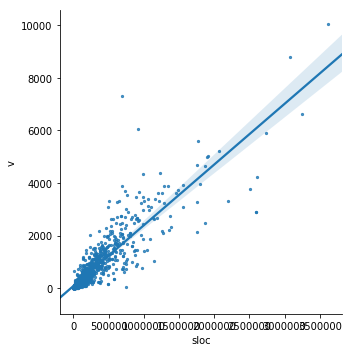

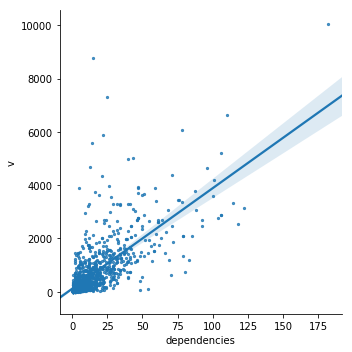

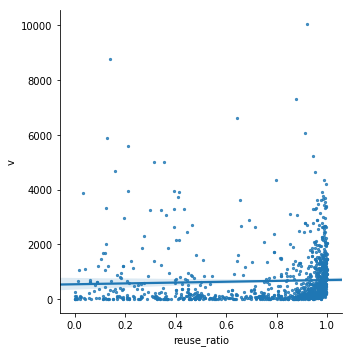

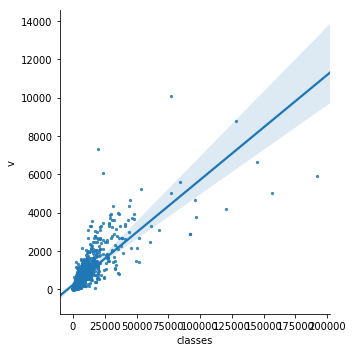

In [5]:
# print plots with regression line

seaborn.lmplot(x='sloc',y='v',data=df,fit_reg=True, scatter_kws={"s": marker_size})
# seaborn.lmplot(x='sloc_z',y='v_z',data=df,fit_reg=True, scatter_kws={"s": marker_size})
seaborn.lmplot(x='dependencies',y='v',data=df,fit_reg=True, scatter_kws={"s": marker_size})
# seaborn.lmplot(x='v_z',y='dependencies_z',data=df,fit_reg=True, scatter_kws={"s": marker_size})
seaborn.lmplot(x='reuse_ratio', y='v',data=df,fit_reg=True, scatter_kws={"s": marker_size})
# seaborn.lmplot(x='reuse_ratio_z',y='v_z',data=df,fit_reg=True, scatter_kws={"s": marker_size})
seaborn.lmplot(x='classes', y='v',data=df,fit_reg=True, scatter_kws={"s": marker_size})
# seaborn.lmplot(x='classes_z',y='v_z',data=df,fit_reg=True, scatter_kws={"s": marker_size})

<a id="rq1-regression-multivariate"></a>
### Multivariate Regression Analysis
Here, we calculate the standardized beta values and perform a multivariate regression analysis on the four factors: _'sloc'_, _'dependencies'_, _'reuse-ratio'_ and _'classes'_.

[Back to table of contents](#index)

In [6]:
# OLS with beta standardized 
ols_model = sm.ols(formula="v_z ~ sloc_z + dependencies_z + reuse_ratio_z + classes_z", data=df)
result = ols_model.fit()

print(result.summary())


                            OLS Regression Results                            
Dep. Variable:                    v_z   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     1217.
Date:                Sat, 02 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:12:35   Log-Likelihood:                -773.15
No. Observations:                1244   AIC:                             1556.
Df Residuals:                    1239   BIC:                             1582.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       3.816e-17      0.013   2.98e

<a id="rq1-boxplots"></a>
### RQ1 - Boxplots


[Back to table of contents](#index)

/home/agkortzis/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


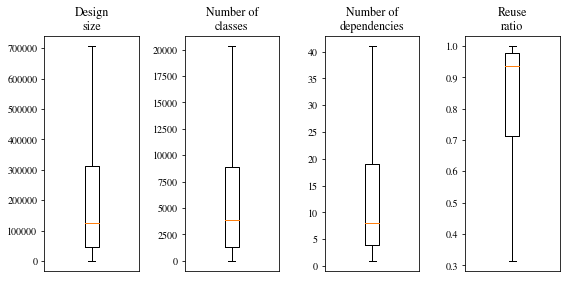

In [7]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(8, 4), tight_layout = {'pad': 1})
bp_vars = ['sloc', 'classes', 'dependencies', 'reuse_ratio'] 
labels = ['Design\nsize', 'Number of\nclasses', 'Number of\ndependencies', 'Reuse\nratio'] 

# Plot boxes
for i in range(len(labels)):
    bxp_df = df[bp_vars[i]]
    axs[i].boxplot(bxp_df, showfliers=False)
    axs[i].set_xticks([])
#     axs[i].set_ylim([-0.0001,0.0065])
#     axs[i].set_ylim([-0.0001,0.0100])
    axs[i].set_title(labels[i])

fig.subplots_adjust(hspace=0.1, wspace=0.5)

plt.savefig("../../paper/figs/boxplots_rq1.pdf")

plt.show()

<a id="rq1-boxplots"></a>
### RQ1 - Boxplots
// TODO description<br>
// Not applicable in the JSS statistical approach

[Back to table of contents](#index)

In [8]:
# import matplotlib
# import matplotlib.pyplot as plt

# %matplotlib inline

# matplotlib.rcParams['mathtext.fontset'] = 'custom'
# matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
# matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
# matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
# matplotlib.rcParams['font.family'] = 'STIXGeneral'


# fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8, 6), tight_layout = {'pad': 1})
# bp_vars = ['#uv', '#uv_classes', '#uv_sloc', '#dv', '#dv_classes', '#dv_sloc']
# cols = ['Number of\nvulnerabilities', 'Number of classes\nwith vulnerabilities', 'Vulnrabilities\nper SLOC']
# rows = ['Native Code', 'Reused Code']

# Plot boxes
# for r in range(len(rows)):
#     for c in range(len(cols)):
#         bxp_df = df[bp_vars[r*len(cols) + c]]
#         axs[r,c].boxplot(bxp_df, showfliers=False)
#         axs[r,c].set_xticks([])

# # Set titles
# for ax, col in zip(axs[0], cols):
#     ax.set_title(col)

# for ax, row in zip(axs[:,0], rows):
#     ax.set_ylabel(row, rotation=90, size='large')


# fig.subplots_adjust(hspace=0.1, wspace=0.5)

# plt.savefig("../../paper/figs/boxplots.pdf")

# plt.show()

<a id="rq1-grouping"></a>
### RQ1 - Grouping analysis
// TODO description <br>
// Not applicable in the JSS statistical approach

[Back to table of contents](#index)

In [9]:
# import numpy as np
# from scipy.stats import ttest_ind

# def splitby_and_test(df, sort_var, test_var):    
#     df.sort_values([sort_var], ascending=[True])
#     dfs = np.array_split(df, 2)
    
#     t = ttest_ind(dfs[0][test_var],dfs[1][test_var])
#     print(f'Comparison of {test_var} for data sorted by {sort_var}')
#     print(f'\tStatistic={t[0]:.2f} (p={t[1]:.2f})')


# # df = load_dataset(projects_dataset)
# # df = prepare_dataset(df)

# splitby_and_test(df, '#u_sloc', '#uv')
# splitby_and_test(df, '#u_sloc', '#dv')
# splitby_and_test(df, '#d_sloc', '#uv')
# splitby_and_test(df, '#d_sloc', '#dv')

<a id="rq2"></a>
## RQ2
__RQ2: "How are potential security vulnerabilities distributed between native and reused code?"__

[Back to table of contents](#index)

<a id="rq2-pd"></a>
### RQ2 - Prepare Dataset
Define new variables for the analysis of RQ2 and calculate their standardized beta values. 
[Back to table of contents](#index)

In [10]:
#
# Define and calculate new variables
#
df['reuse_ratio'] = df['#d_sloc'] / (df['#d_sloc']+df['#u_sloc'])
df['uv_ratio'] = df['#uv'] / df['#u_sloc']
df['dv_ratio'] = df['#dv'] / df['#d_sloc']
df['#v_sloc'] = (df['#uv'] + df['#dv']) / (df['#d_sloc']+df['#u_sloc']) # vulnerability density

#
# Standardize beta coefficient (by z-score)
#
df['reuse_ratio_z'] = df['reuse_ratio'].pipe(stats.zscore)
df['uv_ratio_z'] = df['uv_ratio'].pipe(stats.zscore) # vulnerability density in native code
df['dv_ratio_z'] = df['dv_ratio'].pipe(stats.zscore) # vulnerability density in reused code
df['v_sloc_z'] = df['#v_sloc'].pipe(stats.zscore) # vulnerability density

<a id="rq2-scatter"></a>
### RQ2 - Scatterplots
// TODO description

[Back to table of contents](#index)

/home/agkortzis/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


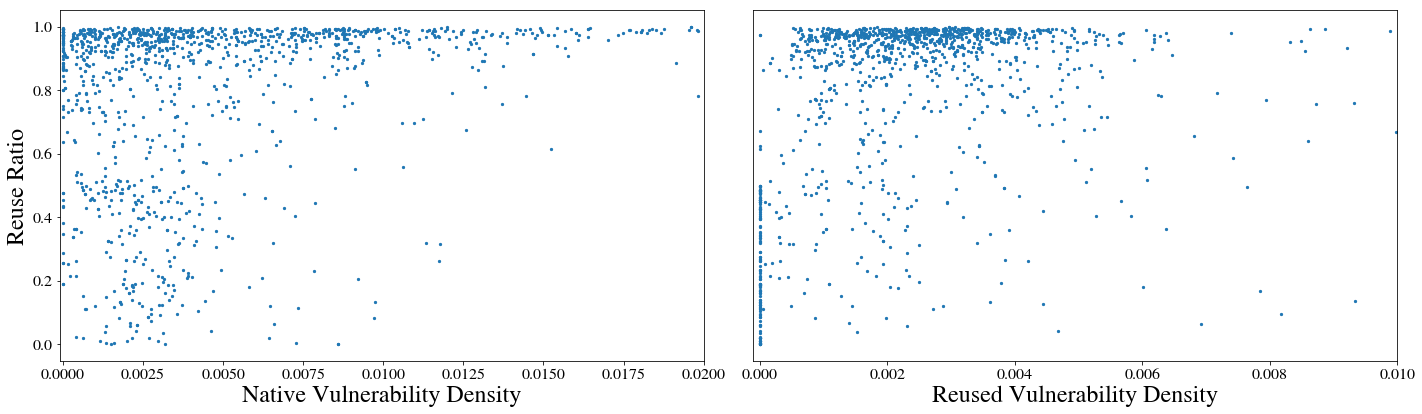

In [11]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 6), tight_layout = {'pad': 1})
label_size = 24

axs[0].scatter(df['uv_ratio'], df['reuse_ratio'],s=5,cmap='bwr')
axs[0].set_xlim([-0.0001,0.02])
axs[0].set_xlabel("Native Vulnerability Density", fontsize=label_size)
axs[0].set_ylabel('Reuse Ratio', rotation=90, fontsize=label_size)
axs[1].scatter(df['dv_ratio'], df['reuse_ratio'],s=5,cmap='bwr')
axs[1].set_xlim([-0.0001,0.01])
axs[1].set_xlabel("Reused Vulnerability Density", fontsize=label_size)
axs[1].set_yticks([])

fig.subplots_adjust(wspace=0.1)
plt.savefig("../../paper/figs/scatter_plots.pdf")
plt.show()

<a id="rq2-boxplots2"></a>
### RQ2 - Boxplots
// TODO description

[Back to table of contents](#index)

/home/agkortzis/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


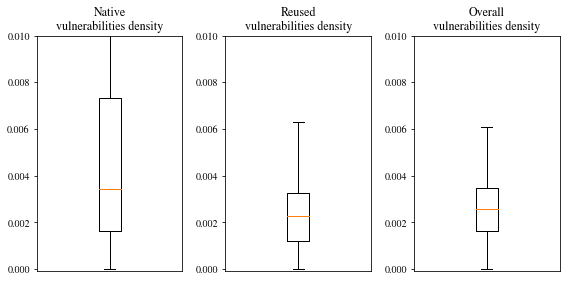

In [12]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8, 4), tight_layout = {'pad': 1})
bp_vars = ['uv_ratio', 'dv_ratio', '#v_sloc'] #'reuse_ratio'
labels = ['Native\nvulnerabilities density', 'Reused\nvulnerabilities density', 'Overall\nvulnerabilities density'] #'Reuse ratio', 

# Plot boxes
for i in range(len(labels)):
    bxp_df = df[bp_vars[i]]
    axs[i].boxplot(bxp_df, showfliers=False)
    axs[i].set_xticks([])
    axs[i].set_ylim([-0.0001,0.0065])
    axs[i].set_ylim([-0.0001,0.0100])
    axs[i].set_title(labels[i])

fig.subplots_adjust(hspace=0.1, wspace=0.5)

plt.savefig("../../paper/figs/boxplots2.pdf")

plt.show()

## TODO update text here

/home/agkortzis/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


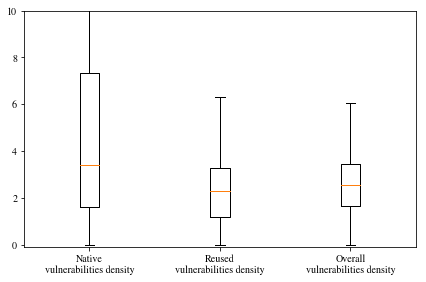

In [29]:
%matplotlib inline

matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# Multiple box plots on one Axes
boxplots_df = [df[bp_vars[0]]*1000, df[bp_vars[1]]*1000, df[bp_vars[2]]*1000]

fig = plt.figure(1, figsize=(6, 4),tight_layout = {'pad': 1})

# fig, ax = plt.subplots(figsize=(10, 6), tight_layout = {'pad': 1})

# Create an axes instance
ax = fig.add_subplot(111)
ax.boxplot(boxplots_df, showfliers=False, widths=0.15)


# ax.set_xticks([])
ax.set_ylim([-0.0001*1000,0.0100*1000])
ax.yaxis.grid(False)
## Custom x-axis labels
ax.set_xticklabels(labels)
ax.set_axisbelow(True)

# Create the boxplot
# bp = ax.boxplot(boxplots_df)
plt.savefig("../../paper/figs/boxplots_rq2_compact.pdf")
plt.show()

<a id="rq2-regression"></a>
### RQ2 - Regression Analysis [vuln-density, reuse-ratio]
In the following analysis we investigate how reuse ratio in a project is related to its vulnerability density. 

The results show that there is no evidence that these two variables are somehow related.

[Back to table of contents](#index)

                            OLS Regression Results                            
Dep. Variable:               v_sloc_z   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6064
Date:                Sat, 02 Nov 2019   Prob (F-statistic):              0.436
Time:                        18:12:37   Log-Likelihood:                -1764.9
No. Observations:                1244   AIC:                             3534.
Df Residuals:                    1242   BIC:                             3544.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.903e-17      0.028  -1.38e-15

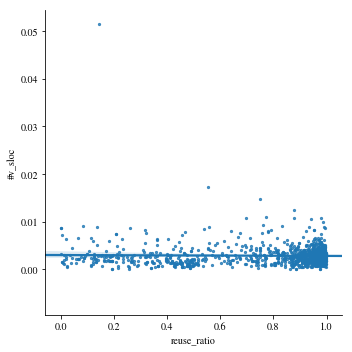

In [14]:
# OLS with beta standardized 
df['v_sloc'] = df['#v_sloc']
ols_model = sm.ols(formula="v_sloc_z ~ reuse_ratio_z", data=df)
result = ols_model.fit()

print(result.summary())

seaborn.lmplot(x='reuse_ratio', y='#v_sloc',data=df,fit_reg=True, scatter_kws={"s": marker_size})

<a id="rq2-regression2"></a>
### RQ2 - Regression Analysis [native-vuln-density, reuse-ratio]
In the following analysis we investigate how reuse ratio in a project is related to its vulnerability density in the native code. 

The results show that there is a weak correlation between the two variables. 
__Very unexpected results__: How can we interprete? 

[Back to table of contents](#index)

                            OLS Regression Results                            
Dep. Variable:             uv_ratio_z   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     52.36
Date:                Sat, 02 Nov 2019   Prob (F-statistic):           8.06e-13
Time:                        18:12:38   Log-Likelihood:                -1739.5
No. Observations:                1244   AIC:                             3483.
Df Residuals:                    1242   BIC:                             3493.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      9.714e-17      0.028   3.49e-15

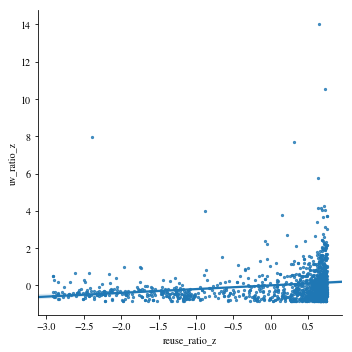

In [15]:
# OLS with beta standardized 
ols_model = sm.ols(formula="uv_ratio_z ~ reuse_ratio_z", data=df)
result = ols_model.fit()

print(result.summary())

seaborn.lmplot(x='reuse_ratio_z', y='uv_ratio_z',data=df,fit_reg=True, scatter_kws={"s": marker_size})

<a id="rq2-regression3"></a>
### RQ2 - Multivariate Regression Analysis [vuln-density, native-sloc, reuse-sloc]
In the following analysis we investigate how native and reused code contribute to the vulnerability density of the project. 
<!--
The results show that there is a weak correlation between the two variables. 
__Very unexpected results__: How can we interprete? 
-->

[Back to table of contents](#index)

In [16]:
# OLS with beta standardized 
ols_model = sm.ols(formula="uv_ratio_z ~ u_sloc_z + d_sloc_z", data=df)
result = ols_model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             uv_ratio_z   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     12.73
Date:                Sat, 02 Nov 2019   Prob (F-statistic):           3.36e-06
Time:                        18:12:39   Log-Likelihood:                -1752.5
No. Observations:                1244   AIC:                             3511.
Df Residuals:                    1241   BIC:                             3526.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9.714e-17      0.028   3.46e-15      1.0

<a id="rq2-regression4"></a>
### RQ2 - Multivariate Regression Analysis [vuln-density, native-vuln-density, reuse-vuln-density]
In the following analysis we investigate how native and reused code contribute to the vulnerability density of the project. 

[Back to table of contents](#index)

In [17]:
# OLS with beta standardized 
ols_model = sm.ols(formula="v_sloc_z ~ uv_ratio_z + dv_ratio_z", data=df)
result = ols_model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               v_sloc_z   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     870.4
Date:                Sat, 02 Nov 2019   Prob (F-statistic):          5.96e-237
Time:                        18:12:39   Log-Likelihood:                -1219.9
No. Observations:                1244   AIC:                             2446.
Df Residuals:                    1241   BIC:                             2461.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.903e-17      0.018  -2.13e-15      1.0

<a id="rq3"></a>
## RQ3
__RQ3: "To What extent do open source projects suffer from vulnerabilities introduced through dependencies?"__.
For that RQ we collect information from the the OWASP dependenvcy-check tool in order to find how projects may use 

[Back to table of contents](#index)


<a id="rq3-dd"></a>
### RQ3 - Dataset Description
Vizualize how projects are distributed based to the number of their disclosed vulnerabilities. 

[Back to table of contents](#index)

In [18]:
# df = load_dataset(projects_dataset)
# df = prepare_dataset(df)
# df = enhance_dataset(df, projects_dependencies, projects_vulnerabilities)
# df = df['#cves'] > 0

sns.set(font_scale=1.1)
ax = sns.violinplot(y=df['#cves'])
fig = ax.get_figure()
ax.set_xlabel("Disclosed Vulnerabilities in Projects")
ax.set_ylabel("Observed values")

fig.savefig('../../paper/figs/rq3_violin.pdf')


# seaborn.violinplot(y=df['#cves'])

NameError: name 'sns' is not defined

<a id="rq3-regression"></a>
### RQ3 - Regression Analysis [#cves - #dependencies]
Perform a regression analysis to investigate how the number of the disclosed vulnerabilities of a project is related to the number of its dependencies.

[Back to table of contents](#index)

In [ ]:
# OLS with beta standardized 
ols_model = sm.ols(formula="cves_z ~ dependencies_z", data=df)
result = ols_model.fit()

print(result.summary())

# print plots with regression line
seaborn.lmplot(x='dependencies',y='cves',data=df,fit_reg=True, scatter_kws={"s": marker_size})


<a id="rq3-regression-potential"></a>
### RQ3 - Regression Analysis [#v - #dependencies]

Perform a regression analysis to investigate how the number of the disclosed vulnerabilities of a project is related to the number of its dependencies.

[Back to table of contents](#index)

In [ ]:
# OLS with beta standardized 
ols_model = sm.ols(formula="v_z ~ dependencies_z", data=df)
result = ols_model.fit()

print(result.summary())

# print plots with regression line
seaborn.lmplot(x='dependencies',y='v',data=df,fit_reg=True, scatter_kws={"s": marker_size})


<a id="rq3-regression2"></a>
### RQ3 - Regression Analysis [#cves - #module_size]
Perform a regression analysis to investigate how the number of the disclosed vulnerabilities of a project is related to the size of its dependencies.

The results show that the size of a module(dependency) is not related to the number of its disclosed vulnerablities. 

[Back to table of contents](#index)

In [ ]:
# OLS with beta standardized 
ols_model = sm.ols(formula="cves_z ~ dependency_size_z", data=df)
result = ols_model.fit()

print(result.summary())

# print plots with regression line
seaborn.lmplot(x='dependency_size',y='cves',data=df,fit_reg=True, scatter_kws={"s": marker_size})

<a id="rq3-regression3"></a>
### RQ3 - Regression Analysis [#cve-density - #dependencies]
Perform a regression analysis to investigate how the cve density of a project is related to the number of its dependencies.

[Back to table of contents](#index)

In [ ]:
df = df[df['cve_density'] < 0.2] # filter a great outlier

# OLS with beta standardized 
ols_model = sm.ols(formula="cve_density_z ~ dependencies_z", data=df)
result = ols_model.fit()

print(result.summary())

seaborn.lmplot(x='dependencies', y='cve_density',data=df,fit_reg=True, scatter_kws={"s": marker_size})

<a id="rq3-regression-multi"></a>
### RQ3 - Multivariate Regression Analysis
Perform a multivariate regression analysis to investigate how the cves of a project is related to the following variables: number of its dependencies, size of the depndencies, reused_code.

[Back to table of contents](#index)

In [ ]:
# OLS with beta standardized 
ols_model = sm.ols(formula="cves_z ~ dependencies_z + dependency_size_z + d_sloc_z", data=df)
result = ols_model.fit()

print(result.summary())

In [ ]:
# print plots with regression line

seaborn.lmplot(x='dependencies_z',y='cves_z',data=df,fit_reg=True, scatter_kws={"s": marker_size})
seaborn.lmplot(x='dependency_size_z',y='cves_z',data=df,fit_reg=True, scatter_kws={"s": marker_size})
seaborn.lmplot(x='d_sloc_z', y='cves_z',data=df,fit_reg=True, scatter_kws={"s": marker_size})
seaborn.lmplot(x='dependency_size_z',y='d_sloc_z',data=df,fit_reg=True, scatter_kws={"s": marker_size})
seaborn.lmplot(x='dependencies_z',y='d_sloc_z',data=df,fit_reg=True, scatter_kws={"s": marker_size})



<a id="rq3-count"></a>
### RQ3 - Vulnerable projects
The following script identifies projects that contain at least one vulnerable dependency.

[Back to table of contents](#index)

In [ ]:
vul_projects = df[df['#cves'] > 0]
print("Vulnerable projects {} out of {} [{:2.2%}]".format(len(vul_projects.index), len(df.index), len(vul_projects.index)/len(df.index)))

<a id="rq4"></a>
## RQ4
__RQ4: "How is the use frequency of a dependency related to its disclosed vulnerabilities"__.
For this RQ we: 
1. Generate the dataset and present the descriptive statistics,
2. Count the vulnerable dependencies
3. Perform a univariate regression analysis between the number of vulnerabilities and its use frequency.

[Back to table of contents](#index)


<a id="rq4-pd"></a>
### RQ4 - Prepare dataset
The following code generates the dataset used for answering RQ4 and presents its descriptive statistics. 
[Back to table of contents](#index)

In [ ]:
import csv
import logging
import pandas as pd

logging.basicConfig(level=logging.INFO)

def get_dependencies(dependencies_usages):
    dependencies = []
    with open(dependencies_usages, 'r') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=';')
        for row in csv_reader:
            logging.debug("{}::{}".format(row[0],row[1]))
            dependencies.append([row[0],row[1]])
    
    return dependencies


def get_vulnerabilities(owasp_vulnerabilities):
    dependencies_vulns = {}
    with open(owasp_vulnerabilities, 'r') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=';')
        for row in csv_reader:
            logging.debug("{}::{}".format(row[0],row[1]))
            dependencies_vulns[row[0]] = row[1]
    
    return dependencies_vulns

def get_potential_vulnerabilities(depependencies_spotbugs):
    depependencies_potential_vulns = {}
    with open(depependencies_spotbugs, 'r') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=';')
        for row in csv_reader:
            logging.debug("{}::{}".format(row[0],row[1]))
            depependencies_potential_vulns[row[0]] = row[1]
    
    return depependencies_potential_vulns
    
    
def create_dataset(dependencies_usages, owasp_vulnerabilities, depependencies_spotbugs):
    dependencies = get_dependencies(dependencies_usages)
    logging.info("Dependencies with usages :: {}".format(len(dependencies)))
    dependencies_vulns = get_vulnerabilities(owasp_vulnerabilities)
    logging.info("Dependencies with vulnerabilities :: {}".format(len(dependencies_vulns)))
    depependencies_potential_vulns = get_potential_vulnerabilities(depependencies_spotbugs)
    logging.info("Dependencies with potential vulnerabilities :: {}".format(len(depependencies_potential_vulns)))
    data = []
    
    logging.info("Creating dataset...")
    for entry in dependencies:
        logging.debug("Parsing usage dependency :: {}".format(entry))
        dependency = entry[0]
        usages = int(entry[1])
        vulns = 0
        potential_vulns = 0
        if dependency not in dependencies_vulns:
            logging.warning("Dependency not in owasp reports :: {}".format(dependency))
        else:
            vulns = int(dependencies_vulns[dependency])
        if dependency not in depependencies_potential_vulns:
            logging.warning("Dependency not in spotbugs reports :: {}".format(dependency))
        else:
            potential_vulns = int(depependencies_potential_vulns[dependency])
            
        data_entry = [dependency, usages, vulns, potential_vulns]
        data.append(data_entry)
    
    return data

owasp_vulnerabilities = '../owasp_vulnerabilities.csv'
dependencies_usages = '../depependencies_usages.csv'
depependencies_spotbugs = "../depependencies_spotbugs.csv"

data = create_dataset(dependencies_usages, owasp_vulnerabilities, depependencies_spotbugs)
logging.info("Created dataset with {} entries".format(len(data)))
# print(data[1:10])
df_vulnerable = pd.DataFrame(data, columns = ['Dependency', 'Usages', 'Vulnerabilities', 'Potential_vulns'])
# df_vulnerable[1:10]
df_vulnerable.describe()

<a id="rq4-count"></a>
### RQ4 - Count Vulnerable dependencies
In this step we analyze the dependencies used in the projects and report those that are vulnerable with at least one disclosed vulnerability. 

[Back to table of contents](#index)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

# df_vulnerable[1:10]
df_vulnerable_filtered = df_vulnerable[df_vulnerable['Vulnerabilities'] > 0] # exclude non-vulnerable dependencies
df_vulnerable_filtered = df_vulnerable_filtered[df_vulnerable_filtered['Vulnerabilities'] < 40] # exclude one extreme (outlier) value
# df_vulnerable = df_vulnerable[df_vulnerable['Usages'] < 40] # exclude one extreme (outlier) value

print("Found {} vulnerable dependencies out of {} total [{:2.2%}]".format(len(df_vulnerable_filtered.index), len(df_vulnerable.index), len(df_vulnerable_filtered.index)/len(df_vulnerable.index)))

sns.set(font_scale=1.1)
ax = sns.violinplot(y=df_vulnerable_filtered['Vulnerabilities'])
fig = ax.get_figure()
ax.set_ylabel("Disclosed Vulnerabilities")
fig.savefig('../../paper/figs/rq4_violin.pdf')
# df_vulnerable_filtered.plot(kind='scatter',x='Usages',y='Vulnerabilities',color='red')
# df_vulnerable[1:10]


<a id="rq4-regression"></a>
### RQ4 - Regression Analysis [CVEs - Usages]


[Back to table of contents](#index)

In [ ]:
# todo zero values
df_vulnerable_filtered['Vulnerabilities_z'] = df_vulnerable_filtered['Vulnerabilities'].pipe(stats.zscore)
df_vulnerable_filtered['Usages_z'] = df_vulnerable_filtered['Usages'].pipe(stats.zscore)

# OLS with beta standardized 
ols_model = sm.ols(formula="Vulnerabilities_z ~ Usages_z", data=df_vulnerable_filtered)
result = ols_model.fit()

print(result.summary())

# print plots with regression line
# seaborn.lmplot(x='sloc',y='v',data=df,fit_reg=True, scatter_kws={"s": marker_size})
seaborn.lmplot(x='Vulnerabilities_z',y='Usages_z',data=df_vulnerable_filtered,fit_reg=True, scatter_kws={"s": marker_size})


<a id="rq4-regression2"></a>
### RQ4 - Regression Analysis [Potential Vulns - Usages]


[Back to table of contents](#index)

In [ ]:
df_vulnerable_filtered['Potential_vulns_z'] = df_vulnerable_filtered['Potential_vulns'].pipe(stats.zscore)

# OLS with beta standardized 
ols_model = sm.ols(formula="Potential_vulns_z ~ Usages_z", data=df_vulnerable_filtered)
result = ols_model.fit()

print(result.summary())

# print plots with regression line
seaborn.lmplot(x='Usages',y='Potential_vulns',data=df_vulnerable_filtered,fit_reg=True, scatter_kws={"s": marker_size})


<a id="discussion"></a>
## [Discussion] How are potential vulnerabilities related to disclosed ones?

[Back to table of contents](#index)

In [ ]:
# OLS with beta standardized 
ols_model = sm.ols(formula="cves_z ~ dv_z", data=df)
result = ols_model.fit()

print(result.summary())

# print plots with regression line
# seaborn.lmplot(x='sloc',y='v',data=df,fit_reg=True, scatter_kws={"s": marker_size})
seaborn.lmplot(x='cves_z',y='dv_z',data=df,fit_reg=True, scatter_kws={"s": marker_size})
